# ECS708P mini-project submission

Ivan Mak

# Summary


In this mini-project, a neural network was built using TensorFlow and Keras to predict the intonation in the basic solution.

The neural network model was borrowed from TensorFlow's tutorial at https://www.tensorflow.org/tutorials/audio/simple_audio. 

The advanced solution tries to predict a sequence of spoken single digits, for example transcribing verification codes in voice phone two-factor authentication.

# Runtime Setup

Here we install and import all the libraries that will be used.


In [ ]:
!pip install kerastuner pydub

In [1]:
# Common stuffs for both basic and advanced solutions
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import (
    layers, models, metrics,
    callbacks, optimizers, losses)
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os, sys, re, pickle, glob
import zipfile, librosa, random, wave
from io import BytesIO
from pydub import AudioSegment
import IPython.display as ipd
from tqdm import tqdm
from pydub import AudioSegment
from pydub.silence import split_on_silence
from datetime import datetime

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Copying the audio samples from Google Drive to the temporary storage of the Colab Runtime

In [2]:
%cp /content/drive/MyDrive/Data/MLEnd/training.zip /content/

In [3]:
directory_to_extract_to = '/content/training/'
with zipfile.ZipFile('/content/training.zip', 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
audio_dir = '/content/training/Training/'
# audio_dir = '/content/drive/MyDrive/Data/MLEnd/training/Training/'

# 1 Basic solution


## Inspecting some audio samples

In [5]:
def display_audio(file_name, use_full_path=False):
    if use_full_path:
        full_path = file_name
    else:
        full_path = audio_dir + file_name
    
    display(ipd.Audio(full_path))
    x, fs = librosa.load(full_path,sr=22050)
    t = np.arange(len(x))/fs
    plt.plot(t,x)
    plt.xlabel('time (sec)')
    plt.ylabel('amplitude')
    plt.show()

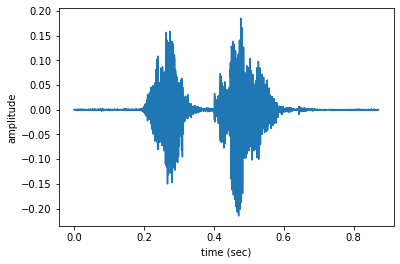

In [ ]:
for _ in range(1):
    n = np.random.randint(20000)
    display_audio(files[n], use_full_path=True)

## Labels Information

### Reading labels data set

This is the data set describing all the 20000 audio samples.

In [6]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


```digit_label``` was inferred as int64 and ```intonation``` was inferred as an object, but we will be doing categorical classification later, so here we change the data type from int64 to category. Also, a new column is added to the data frame as the label ID that will be predicted by the classier.

In [7]:
labels.digit_label = labels.digit_label.astype('category')
labels['digit_label_code'] = labels.digit_label.cat.codes

labels.intonation = labels.intonation.astype('category')
labels['intonation_code'] = labels.intonation.cat.codes

In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   File ID           20000 non-null  object  
 1   digit_label       20000 non-null  category
 2   participant       20000 non-null  object  
 3   intonation        20000 non-null  category
 4   digit_label_code  20000 non-null  int8    
 5   intonation_code   20000 non-null  int8    
dtypes: category(2), int8(2), object(2)
memory usage: 392.4+ KB


### Visualisation of some key fields

#### Distribution of audio samples w.r.t. ```numerals```

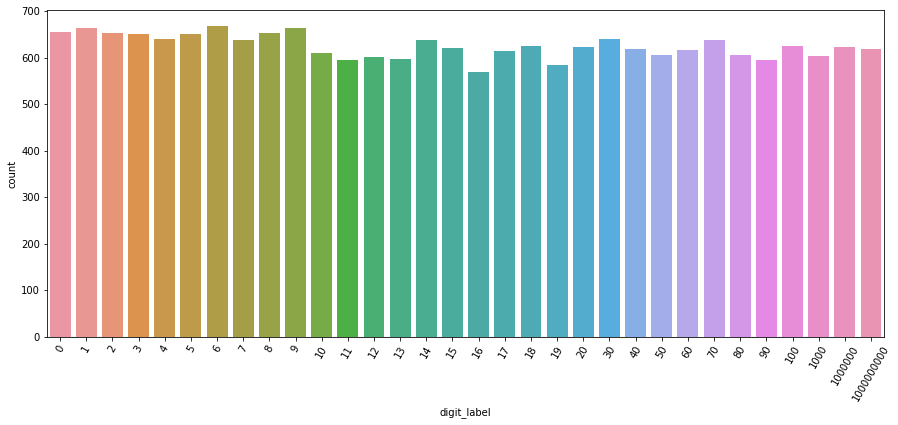

In [ ]:
plt.figure(figsize=(15,6))
sb.countplot(data=labels, x='digit_label')
plt.xticks(fontsize=10, rotation=60)
plt.show()

#### Distribution of audio samples w.r.t. ```partipants```

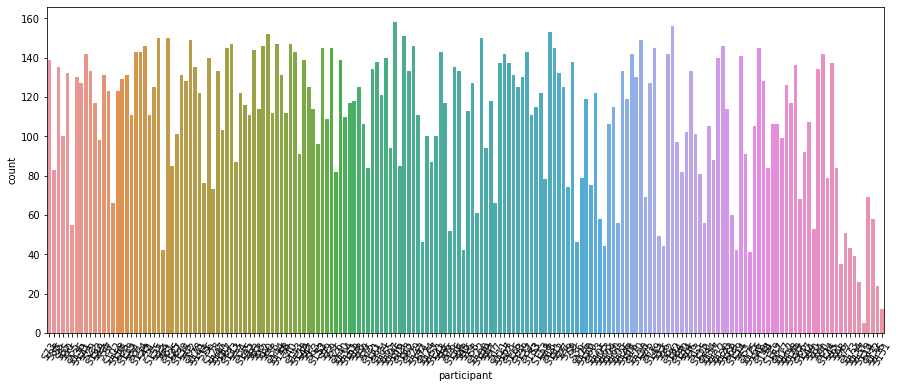

In [ ]:
plt.figure(figsize=(15,6))
sb.countplot(data=labels, x='participant')
plt.xticks(fontsize=10, rotation=60)
plt.show()

#### Distribution of audio samples w.r.t. ```intonation```

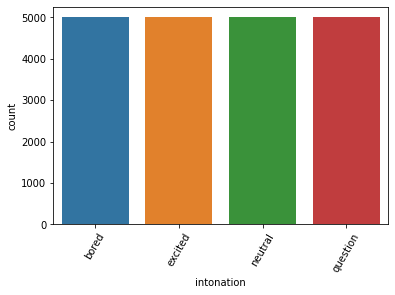

In [ ]:
plt.figure(figsize=(6,4))
sb.countplot(data=labels, x='intonation')
plt.xticks(fontsize=10, rotation=60)
plt.show()

## Implementation

### Introduction

### Data Preprocessing

The first attempt will be based on 20% of the data set, i.e. 4000 audio samples. The same random seed will be used every time to give the same results even after the Colab runtime is restarted.

In [10]:
labels_shuffled = labels.sample(frac=1, random_state=1841)
labels_shuffled

,File ID,digit_label,participant,intonation,digit_label_code,intonation_code
1743,0001743.wav,19,S158,question,19,3
18144,0018144.wav,1000,S165,question,29,3
15571,0015571.wav,50,S165,question,23,3
19084,0019084.wav,0,S89,bored,0,0
6436,0006436.wav,3,S83,excited,3,1
...,...,...,...,...,...,...
3685,0003685.wav,17,S155,excited,17,1
19351,0019351.wav,19,S43,neutral,19,2
5767,0005767.wav,17,S117,question,17,3
9321,0009321.wav,8,S169,excited,8,1


In [11]:
numerals = np.array(sorted(labels_shuffled.digit_label.unique()))

In [12]:
numerals

array([         0,          1,          2,          3,          4,
                5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,
               15,         16,         17,         18,         19,
               20,         30,         40,         50,         60,
               70,         80,         90,        100,       1000,
          1000000, 1000000000])

In [13]:
intonations = np.array(sorted(labels_shuffled.intonation.unique()))

In [14]:
intonations

array(['bored', 'excited', 'neutral', 'question'], dtype='<U8')

In [16]:
train_size = int(len(labels_shuffled) * 0.6)
test_val_size = int((len(labels_shuffled) - train_size) / 2)

In [17]:
print(f"Training size: {train_size}, test size: {test_val_size}, validation size: {test_val_size}")

Training size: 12000, test size: 4000, validation size: 4000


TensorFlow comes with built-in libraries to decode audio files and extract features, as well as built-in ```Dataset``` objects to pipeline data sets.

Similar to RDD in Apache Spark, Tensorflow's ```Dataset``` does not have to fit all data into memory, so it would be beneficial to this project as there are 20000 audio samples.

The following method would read a audio sample of the given file name, and then decode the audio wave into a tensor of floating points.

In [15]:
def decode_audio(file_name):
    file_path = audio_dir + file_name
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

The following method converts a audio wave (represented in a tensor of floating points) into a spectrogram (also represented in a tensor of floating points) by using the short-time Fourier transform function in ```tf.signal``` module. The spectrogram would be stored in a 2-D tensor.

Since the audio samples have different length, but a CNN would require all inputs to have the same shape, so this method would also fill zeros to the resulting tensor so all tensors would have the same shape.

In [16]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([240000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram

After defining the methods to process the audio samples, the following parts would transform the ```labels``` data frame into training, testing, and validation ```Dataset```.

First, the columns ```File ID``` and ```digit_label_code``` are converted into two different ```tf.data.Dataset``` objects.

In [20]:
train_file_ds = tf.data.Dataset.from_tensor_slices(labels_shuffled.iloc[:train_size]['File ID'])
train_label_ds = tf.data.Dataset.from_tensor_slices(labels_shuffled.iloc[:train_size]['intonation_code'])

The ```map``` method in ```tf.data.Dataset``` applies the specified method to each "row" in the data set. In the ```train_file_ds``` data set, the only attribute is the file name. So the ```map``` action is to call the method ```decode_audio``` defined above, to decode the audio files into audio waves and save them into a new ```tf.data.Dataset``` object.

The second block below (with a ```.take()``` method) is to check things did not go wrong.

In [21]:
train_waveform_ds = train_file_ds.map(decode_audio)

In [22]:
for x in train_waveform_ds.take(2):
    print(x)

tf.Tensor(
[ 9.1552734e-05 -9.1552734e-05 -1.5258789e-04 ... -9.1552734e-05
 -2.4414062e-04  0.0000000e+00], shape=(56270,), dtype=float32)
tf.Tensor(
[-0.00033569 -0.00042725 -0.00039673 ... -0.00033569 -0.00036621
 -0.00030518], shape=(33536,), dtype=float32)


After obtaining a ```Dataset``` of the audio waves, the following blocks convert the audio waves into spectrograms.

In [23]:
train_spectrogram_ds = train_waveform_ds.map(get_spectrogram)

With the spectrograms ready, the method ```tf.data.Dataset.zip``` is used to "concatenate" two ```Dataset``` into one, in which the last ```Dataset``` (i.e. ```train_label_ds```) will be considered as the label.

In [24]:
train_ds = tf.data.Dataset.zip((train_spectrogram_ds, train_label_ds))

In [25]:
for x, y in train_ds.take(1):
    print(x.shape)
    print(y)

(1874, 129, 1)
tf.Tensor(3, shape=(), dtype=int8)


Similar to the training ```Dataset``` created above, the following blocks create the testing set and validation set.

In [39]:
def filename_labels_to_ds(file_df, labels_df):
    file_ds = tf.data.Dataset.from_tensor_slices(file_df)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels_df)
    waveform_ds = file_ds.map(decode_audio)
    spectrogram_ds = waveform_ds.map(get_spectrogram)
    output_ds = tf.data.Dataset.zip((spectrogram_ds, labels_ds))
    return output_ds

In [40]:
def filename_to_ds(file_df):
    file_ds = tf.data.Dataset.from_tensor_slices(file_df)
    waveform_ds = file_ds.map(decode_audio)
    spectrogram_ds = waveform_ds.map(get_spectrogram)
    return spectrogram_ds

In [29]:
train_file_df = labels_shuffled.iloc[:train_size]['File ID']
train_labels_df = labels_shuffled.iloc[:train_size]['intonation_code']
train_ds = filename_labels_to_ds(train_file_df, train_labels_df)

In [30]:
test_file_df = labels_shuffled.iloc[train_size: train_size + test_val_size]['File ID']
test_labels_df = labels_shuffled.iloc[train_size: train_size + test_val_size]['intonation_code']
test_ds = filename_labels_to_ds(test_file_df, test_labels_df)

In [31]:
val_file_df = labels_shuffled.iloc[-test_val_size:]['File ID']
val_labels_df = labels_shuffled.iloc[-test_val_size:]['intonation_code']
val_ds = filename_labels_to_ds(val_file_df, val_labels_df)

When using ```tf.data.Dataset```, it is required to call the ```batch()``` method to split the dataset into smaller batches.

With the ```Dataset``` that is already separated into batches, the parameter ```batch_size``` would not be needed when fitting a neural network model.

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [32]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


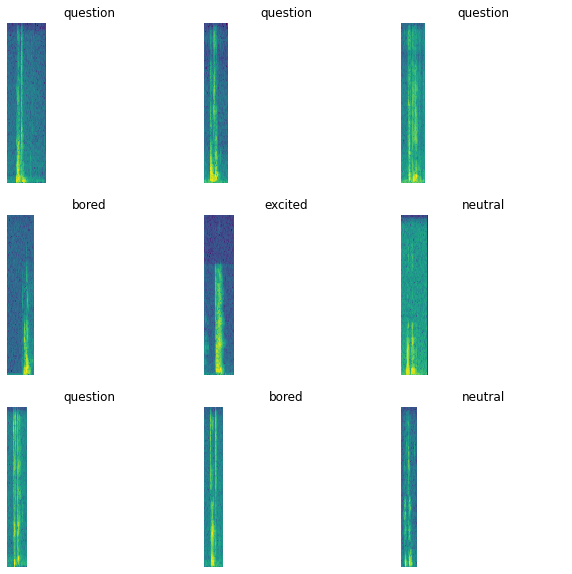

In [36]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(f'{intonations[label_id]}')
  ax.axis('off')

plt.show()

### Building a Neural Network

This section is about building a neural network to classify the spectrogram.

Note: The notebook should be connected to a GPU-enabled Colab runtime prior to fitting the neural network.

The following codes save the shape of the spectrogram tensors, and the number of classes into two variables, which would be referenced when the CNN is built.

In [31]:
for spectrogram in train_spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (1874, 129, 1)


In [32]:
#num_labels = len(numerals)
num_labels = len(intonations)

The ```Normalization``` layer is to force the inputs into a distribution centered around 0 with standard deviation 1.

Unlike ```sklearn.preprocess.Normalizer```, TensorFlow's ```Normalization``` layer does not have an equivalent method to ```fit_transform()```. Instead, the ```adapt()``` method is similar to ```fit()``` in sklearn, and the actual transformation would be done when the tensors are passed through this layer in the model.

In [33]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda x: x))

The code below defines a functional model that consists of the following layers.

*   A ```Resizing``` layer to down-sample the inputs for faster processing.
*   The ```Normalization``` layer created above to normalise the inputs.
*   2 ```Conv2D``` 2D convolution layers over the spectrograms, which are stored as 2D tensors.
*   A ```MaxPool2D``` layer to perform max pooling operation.
*   A ```Flatten``` layer to linearise the tensors before passing them onto the subsequent densely-connected layers.
*   A ```Dense``` densely-connected layer using the activation function ```relu```, followed by a ```Dropout``` layer of 50% dropout rate.
*   A final ```Dense``` layer of number of units defined in ```num_labels```. The activation function ```softmax``` is used so that each neuron in the output layer would produce a probability of which intonation the spectrogram belongs to.




In [34]:
input_layer = layers.Input(shape=input_shape)
resize = preprocessing.Resizing(128, 128)(input_layer)
normalization = norm_layer(resize)
conv2d = layers.Conv2D(32, 3, activation='relu')(normalization)
conv2d = layers.Conv2D(64, 3, activation='relu')(conv2d)
pooling = layers.MaxPooling2D()(conv2d)
flattened = layers.Flatten()(pooling)
dense = layers.Dense(128, activation='relu')(flattened)
dense = layers.Dropout(0.5)(dense)
output_layer = layers.Dense(num_labels, activation='softmax')(dense)

simpler_model = keras.models.Model(input_layer, output_layer)
simpler_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [35]:
simpler_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1874, 129, 1)]    0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 1)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0     

In [36]:
EPOCHS = 200
history_simpler_model = simpler_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
)

Epoch 1/200
188/188 [==============================] - 736s 4s/step - loss: 1.3715 - accuracy: 0.4129 - val_loss: 1.0528 - val_accuracy: 0.5627
Epoch 2/200
188/188 [==============================] - 9s 47ms/step - loss: 1.0526 - accuracy: 0.5525 - val_loss: 0.9875 - val_accuracy: 0.5972
Epoch 3/200
188/188 [==============================] - 9s 47ms/step - loss: 0.9531 - accuracy: 0.6024 - val_loss: 0.9747 - val_accuracy: 0.6065
Epoch 4/200
188/188 [==============================] - 9s 47ms/step - loss: 0.8802 - accuracy: 0.6390 - val_loss: 0.9625 - val_accuracy: 0.6200
Epoch 5/200
188/188 [==============================] - 9s 47ms/step - loss: 0.7969 - accuracy: 0.6782 - val_loss: 0.9571 - val_accuracy: 0.6340
Epoch 6/200
188/188 [==============================] - 9s 47ms/step - loss: 0.7213 - accuracy: 0.7102 - val_loss: 0.9505 - val_accuracy: 0.6382
Epoch 7/200
188/188 [==============================] - 9s 47ms/step - loss: 0.6472 - accuracy: 0.7385 - val_loss: 0.9712 - val_accuracy:

In [37]:
metrics = history_simpler_model.history

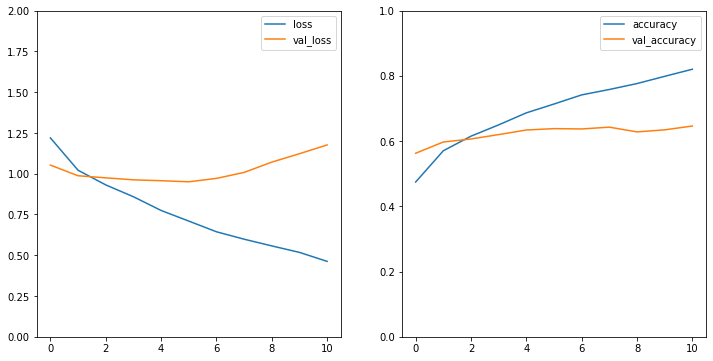

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_simpler_model.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim(0, 2)
plt.subplot(122)
plt.plot(history_simpler_model.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim(0, 1)
plt.show()

In [41]:
keras.models.save_model(simpler_model, '/content/drive/MyDrive/Data/MLEnd/intonation_CNN_20210409_simpler')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/MLEnd/intonation_CNN_20210409_simpler/assets


### Searching for a (Potentially) Better Model

Most tutorial blog posts on the Internet would suggest increasing the number of layers in the neural network can improve the prediction accuracy, and this section tries to find if the a more complex model is better.

To find out the best hyper-parameters to build the model, the library ```keras-tuner``` comes handy for hyper-parameter searching.

Since it does not come with the Colab runtime, it has to been installed before searching for the best hyper-parameters.

However, because of the complexity of the CNN model, the free Colab runtime might run out of memory when searching for the best hyper-parameters. However, this did not affect me because Colab Pro was launched in the UK very recently and I've signed up for that as soon as it became available. The following blocks ran successfully on a Colab Pro runtime with 24GB memory allowance (runtime shape = High RAM).

The following method builds a model using a set of hyper-parameters being tested by keras-tuner.

In [43]:
max_intermediate_layers = 2

def build_model(hp: HyperParameters):
    dropout_ratio = hp.Choice('dropout_ratio', [0.125, 0.25, 0.5])
    num_intermediate_conv2d = hp.Int('num_intermediate_conv2d', 0, max_intermediate_layers)
    num_intermediate_dense = hp.Int('num_intermediate_dense', 0, max_intermediate_layers)

    input_layer = layers.Input(shape=input_shape)

    # Resizing layer to 32x32
    resize = preprocessing.Resizing(128, 128)(input_layer)

    # Normalisation
    normalization = norm_layer(resize)
    

    conv2d_filters = 32
    conv2d = layers.Conv2D(conv2d_filters, 3, activation='relu')(normalization)
    
    # Variable number of intermediate Conv2D layers
    for _ in range(0, num_intermediate_conv2d):
        conv2d_filters = conv2d_filters * 2
        conv2d = layers.Conv2D(conv2d_filters, 3, activation='relu')(conv2d)  
    
    # Try whether MaxPooling or AveragePooling is better
    pooling = hp.Choice('pooling', ['maxpooling', 'averagepooling'])
    if pooling == 'maxpooling':
        pooling = layers.MaxPooling2D()(conv2d)
    elif pooling == 'averagepooling':
        pooling = layers.AveragePooling2D()(conv2d)
    
    flattened = layers.Flatten()(pooling)

    num_neurons = conv2d_filters * 2
    dense = layers.Dense(num_neurons, activation='relu')(flattened)
    dense = layers.Dropout(dropout_ratio)(dense)

    # Variable number of Dense layers
    for _ in range(0, num_intermediate_dense):
        num_neurons = num_neurons / 2
        dense = layers.Dense(num_neurons, activation='relu')(dense)
        dense = layers.Dropout(dropout_ratio)(dense)

    # Finaly Dense layer of intonation prediction
    output_layer = layers.Dense(num_labels, activation='softmax')(dense)

    model = keras.models.Model(input_layer, output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model


```keras-tuner``` will save its progress in a directory specified during class instantiation.

In [44]:
%cd /content/drive/MyDrive/Data/MLEnd/keras_tuner/
%pwd

/content/drive/MyDrive/Data/MLEnd/keras_tuner


'/content/drive/MyDrive/Data/MLEnd/keras_tuner'

In [45]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='intonation_tuning',
    project_name='MLEnd')

In [46]:
EPOCHS = 200
history = tuner.search(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)]
)

Trial 5 Complete [00h 05m 52s]
val_loss: 0.928485244512558

Best val_loss So Far: 0.9154432117938995
Total elapsed time: 00h 16m 53s
INFO:tensorflow:Oracle triggered exit


Turns out the best model is not as complex as the search would allow. So, if we built the model with these parameters without running keras-tuner, a Colab Pro runtime would not be necessary as everything should fit into the standard runtime.

The result summary of keras-tuner shows that the loss score has improved from 1.2284 to 0.9306.

In [47]:
tuner.results_summary()

Results summary
Results in intonation_tuning/MLEnd
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dropout_ratio: 0.5
num_intermediate_conv2d: 1
num_intermediate_dense: 1
pooling: maxpooling
Score: 0.9154432117938995
Trial summary
Hyperparameters:
dropout_ratio: 0.125
num_intermediate_conv2d: 2
num_intermediate_dense: 1
pooling: averagepooling
Score: 0.928485244512558
Trial summary
Hyperparameters:
dropout_ratio: 0.125
num_intermediate_conv2d: 1
num_intermediate_dense: 2
pooling: averagepooling
Score: 0.9334640800952911
Trial summary
Hyperparameters:
dropout_ratio: 0.25
num_intermediate_conv2d: 1
num_intermediate_dense: 0
pooling: averagepooling
Score: 0.9492736160755157
Trial summary
Hyperparameters:
dropout_ratio: 0.25
num_intermediate_conv2d: 1
num_intermediate_dense: 0
pooling: maxpooling
Score: 0.9674048125743866


Now a model is built using the best hyper-parameters found by keras-tuner.

In [48]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
kt_model = tuner.hypermodel.build(best_hps)

And the best model determined by ```keras-tuner``` would have 3 Conv2D layers (one layer more than the simple model), and also 3 densely-connected layers excluding the output layer (two layers more than the simple model)

In [49]:
kt_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1874, 129, 1)]    0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 1)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0     

Now the model is being fitted and let's see whether it performs better than the original simpler model.

The fitting results of the simpler model was:

loss: 0.4758 - accuracy: 0.8136 - val_loss: 1.1765 - val_accuracy: 0.6463

In [50]:
EPOCHS = 200
history_kt_model = kt_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
)

Epoch 1/200
188/188 [==============================] - 10s 48ms/step - loss: 1.4175 - accuracy: 0.3487 - val_loss: 1.1564 - val_accuracy: 0.5250
Epoch 2/200
188/188 [==============================] - 9s 47ms/step - loss: 1.1677 - accuracy: 0.5070 - val_loss: 1.0594 - val_accuracy: 0.5627
Epoch 3/200
188/188 [==============================] - 9s 47ms/step - loss: 1.0750 - accuracy: 0.5491 - val_loss: 1.0018 - val_accuracy: 0.5872
Epoch 4/200
188/188 [==============================] - 9s 47ms/step - loss: 0.9707 - accuracy: 0.6029 - val_loss: 0.9611 - val_accuracy: 0.6045
Epoch 5/200
188/188 [==============================] - 9s 47ms/step - loss: 0.8850 - accuracy: 0.6478 - val_loss: 0.9407 - val_accuracy: 0.6120
Epoch 6/200
188/188 [==============================] - 9s 47ms/step - loss: 0.8315 - accuracy: 0.6608 - val_loss: 0.9458 - val_accuracy: 0.6292
Epoch 7/200
188/188 [==============================] - 9s 47ms/step - loss: 0.7406 - accuracy: 0.7007 - val_loss: 0.9242 - val_accuracy

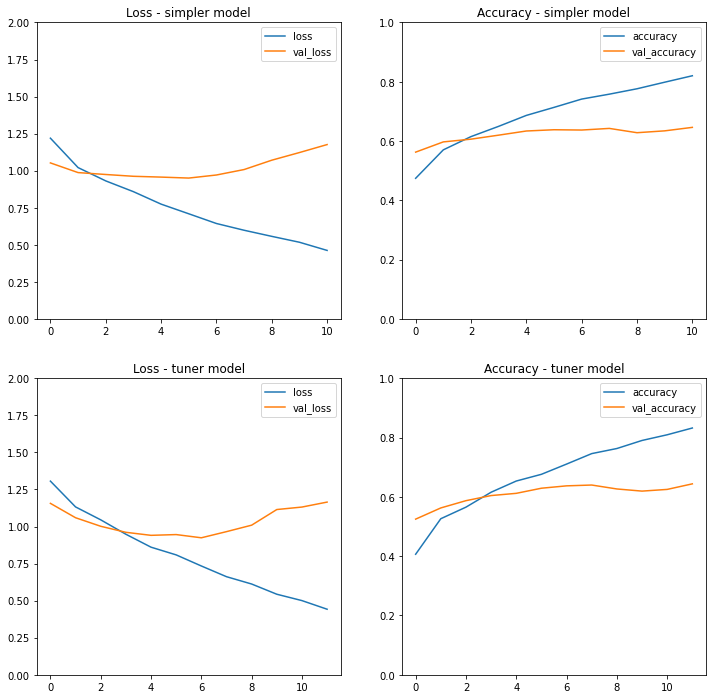

In [52]:
metrics_tuner = history_kt_model.history

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(history_simpler_model.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim(0, 2)
plt.title('Loss - simpler model')

plt.subplot(222)
plt.plot(history_simpler_model.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim(0, 1)
plt.title('Accuracy - simpler model')

plt.subplot(223)
plt.plot(history_kt_model.epoch, metrics_tuner['loss'], metrics_tuner['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim(0, 2)
plt.title('Loss - tuner model')

plt.subplot(224)
plt.plot(history_kt_model.epoch, metrics_tuner['accuracy'], metrics_tuner['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim(0, 1)
plt.title('Accuracy - tuner model')
plt.show()

Finally, the model is saved to Google Drive for subsequent use.

In [53]:
keras.models.save_model(kt_model, '/content/drive/MyDrive/Data/MLEnd/intonation_CNN_20210409_kerastuner')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/MLEnd/intonation_CNN_20210409_kerastuner/assets


### Validation or Testing

Whether it is validation or testing, these two words have similar meaning, but the idea here is to test the neural network with using data that were never used during training.

Since ```val_ds``` was used when fitting the models, The remaining ```test_ds``` will be used here.

It is a good idea to restart the Colab runtime so that unneeded data in the memory are cleared. Therefore, the models have to be reloaded from Google Drive.

In [54]:
simple_tone_model = keras.models.load_model('/content/drive/MyDrive/Data/MLEnd/intonation_CNN_20210409_simpler')
complex_tone_model = keras.models.load_model('/content/drive/MyDrive/Data/MLEnd/intonation_CNN_20210409_kerastuner')

In [55]:
simple_tone_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1874, 129, 1)]    0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 1)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0     

In [56]:
complex_tone_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1874, 129, 1)]    0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 1)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0     

The following blocks evaluate the model using the data set stored in ```test_ds```. Since Colab runtime is restared, ```test_ds``` actually has to be rebuilt by running the preprocesing part above.

In [57]:
test_x, test_y = [], []
for x, y in test_ds:
    test_x.append(x)
    test_y.append(y)

In [58]:
test_x = np.array(test_x)
test_y = np.array(test_y)

In [59]:
simple_tone_model.evaluate(test_x, test_y)

125/125 [==============================] - 2s 15ms/step - loss: 1.1278 - accuracy: 0.6480


[1.1278362274169922, 0.6480000019073486]

In [60]:
complex_tone_model.evaluate(test_x, test_y)

125/125 [==============================] - 2s 15ms/step - loss: 1.0950 - accuracy: 0.6570


[1.0949565172195435, 0.6570000052452087]

It was shown that both models had similar performance in terms of prediction accuracy.

#### Confusion Matrices

In [61]:
y_val_true = test_labels_df.values

##### Simpler Model

In [62]:
#Simpler model
y_proba_simpler = simple_tone_model.predict(test_x)
y_pred_simpler = np.argmax(y_proba_simpler, axis=1)

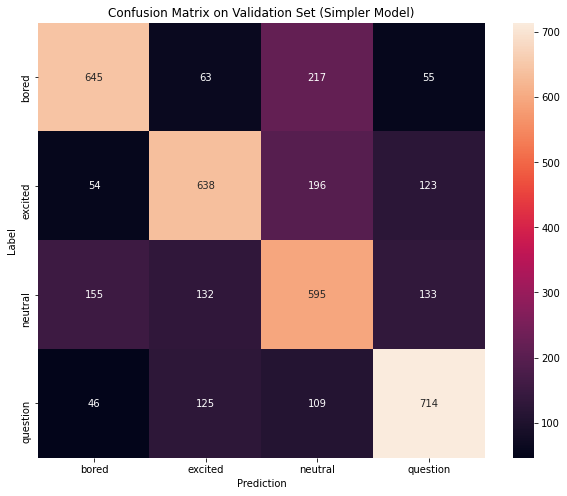

In [63]:
confusion_mtx = tf.math.confusion_matrix(y_val_true, y_pred_simpler) 
plt.figure(figsize=(10, 8))
sb.heatmap(confusion_mtx, xticklabels=intonations, yticklabels=intonations, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix on Validation Set (Simpler Model)')
plt.show()

##### Complex Model

In [64]:
#Complex model
y_proba_complex = complex_tone_model.predict(test_x)
y_pred_complex = np.argmax(y_proba_complex, axis=1)

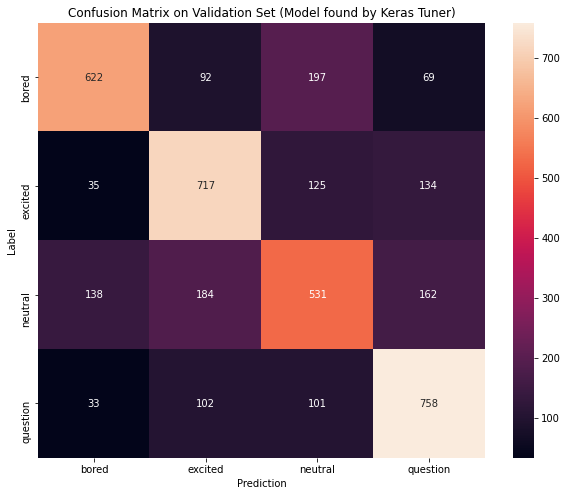

In [65]:
confusion_mtx = tf.math.confusion_matrix(y_val_true, y_pred_complex) 
plt.figure(figsize=(10, 8))
sb.heatmap(confusion_mtx, xticklabels=intonations, yticklabels=intonations, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix on Validation Set (Model found by Keras Tuner)')
plt.show()

#### Comparing the Results

In [66]:
test_df = labels_shuffled.iloc[train_size: train_size + test_val_size]
test_df = test_df.drop(['digit_label_code', 'intonation_code'], axis=1)
test_df['intonation_pred_simple'] = intonations[y_pred_simpler]
test_df['intonation_pred_complex'] = intonations[y_pred_complex]

In [67]:
test_df[((test_df['intonation'] != test_df['intonation_pred_simple']) | (test_df['intonation'] != test_df['intonation_pred_complex'])) & ((test_df['intonation'] == 'bored') | (test_df['intonation'] == 'neutral')) ]

,File ID,digit_label,participant,intonation,intonation_pred_simple,intonation_pred_complex
7947,0007947.wav,12,S102,bored,neutral,neutral
5184,0005184.wav,12,S171,neutral,excited,excited
6189,0006189.wav,11,S144,neutral,excited,excited
2740,0002740.wav,20,S166,neutral,question,question
13549,0013549.wav,17,S103,neutral,bored,bored
...,...,...,...,...,...,...
13345,0013345.wav,40,S73,bored,neutral,neutral
14838,0014838.wav,1,S162,bored,neutral,neutral
14629,0014629.wav,1,S139,neutral,excited,excited
17918,0017918.wav,0,S143,neutral,bored,bored


For example, this audio sample is a bored tone predicted to be a neutral tone by both model.

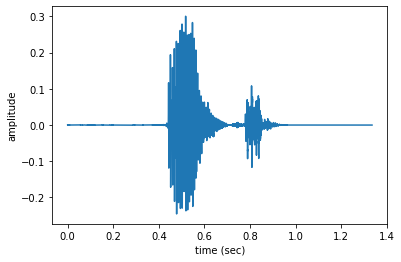

In [70]:
display_audio('0013345.wav')

And this audio sample is a neutral tone, and the simple model predicted excited and the complex model predicted neutral.

Both model eventually achieved the similar accuracy of about 64%, and the correct predictions are more even in the simple model.

And one interesting observation is that both models appear to have difficulty distinguishing bored tone and neutral tone. But it is of no surprise because even for human, it could also be difficult to tell these two tones apart.

Also, one could argue that the participants have different voices when they were asked to specifically speak in these tones, so they may sound different from how they would sound when they are naturally speaking in the particular tone. This would be an inevitable limitation when the audio samples are produced by many different people.

# 2 Advanced solution

## Recognising Single Digits

This section aims to build a model to identify a set of single digit numerals in a sequence. The model is build using similar code to the above section.

In [17]:
single_digits_df = pd.DataFrame(labels)
single_digits_df.digit_label = single_digits_df.digit_label.astype('int64')
single_digits_df = single_digits_df[single_digits_df['digit_label'] < 10]
single_digits_df.digit_label = single_digits_df.digit_label.astype('category')
single_digits_df = single_digits_df.sample(frac=1, random_state=1841)
single_digits_df

,File ID,digit_label,participant,intonation,digit_label_code,intonation_code
18326,0018326.wav,9,S95,question,9,3
15877,0015877.wav,5,S106,bored,5,0
14047,0014047.wav,9,S42,bored,9,0
14572,0014572.wav,7,S39,question,7,3
15731,0015731.wav,4,S111,excited,4,1
...,...,...,...,...,...,...
11039,0011039.wav,7,S91,excited,7,1
5131,0005131.wav,2,S42,excited,2,1
8977,0008977.wav,8,S92,bored,8,0
17543,0017543.wav,2,S27,excited,2,1


In [54]:
train_size = int(len(single_digits_df) * 0.6)
test_val_size = int((len(single_digits_df) - train_size) / 2)
print(f"Training size: {train_size}, test size: {test_val_size}, validation size: {test_val_size}")

Training size: 3919, test size: 1307, validation size: 1307


In [55]:
train_file_ds = tf.data.Dataset.from_tensor_slices(single_digits_df.iloc[:train_size]['File ID'])
train_label_ds = tf.data.Dataset.from_tensor_slices(single_digits_df.iloc[:train_size]['digit_label_code'])

In [56]:
train_waveform_ds = train_file_ds.map(decode_audio)

In [57]:
train_spectrogram_ds = train_waveform_ds.map(get_spectrogram)

In [58]:
train_ds = tf.data.Dataset.zip((train_spectrogram_ds, train_label_ds))

In [59]:
test_file_df = single_digits_df.iloc[train_size: train_size + test_val_size]['File ID']
test_labels_df = single_digits_df.iloc[train_size: train_size + test_val_size]['digit_label_code']
test_ds = filename_labels_to_ds(test_file_df, test_labels_df)

In [60]:
val_file_df = single_digits_df.iloc[-test_val_size:]['File ID']
val_labels_df = single_digits_df.iloc[-test_val_size:]['digit_label_code']
val_ds = filename_labels_to_ds(val_file_df, val_labels_df)

In [61]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [62]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [63]:
for spectrogram in train_spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (1874, 129, 1)


In [64]:
numerals = single_digits_df.digit_label_code.unique()

In [65]:
num_labels = len(numerals)
num_labels

10

In [66]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda x: x))

In [70]:
max_intermediate_layers = 2

def build_model(hp: HyperParameters):
    dropout_ratio = hp.Choice('dropout_ratio', [0.125, 0.25, 0.5])
    num_intermediate_conv2d = hp.Int('num_intermediate_conv2d', 0, max_intermediate_layers)
    num_intermediate_dense = hp.Int('num_intermediate_dense', 0, max_intermediate_layers)

    input_layer = layers.Input(shape=input_shape)

    # Resizing layer to 32x32
    resize = preprocessing.Resizing(128, 128)(input_layer)

    # Normalisation
    normalization = norm_layer(resize)
    

    conv2d_filters = 32
    conv2d = layers.Conv2D(conv2d_filters, 3, activation='relu')(normalization)
    
    # Variable number of intermediate Conv2D layers
    for _ in range(0, num_intermediate_conv2d):
        conv2d_filters = conv2d_filters * 2
        conv2d = layers.Conv2D(conv2d_filters, 3, activation='relu')(conv2d)  
    
    # Try whether MaxPooling or AveragePooling is better
    pooling = hp.Choice('pooling', ['maxpooling', 'averagepooling'])
    if pooling == 'maxpooling':
        pooling = layers.MaxPooling2D()(conv2d)
    elif pooling == 'averagepooling':
        pooling = layers.AveragePooling2D()(conv2d)
    
    flattened = layers.Flatten()(pooling)

    num_neurons = conv2d_filters * 2
    dense = layers.Dense(num_neurons, activation='relu')(flattened)
    dense = layers.Dropout(dropout_ratio)(dense)

    # Variable number of Dense layers
    for _ in range(0, num_intermediate_dense):
        num_neurons = num_neurons / 2
        dense = layers.Dense(num_neurons, activation='relu')(dense)
        dense = layers.Dropout(dropout_ratio)(dense)

    # Finaly Dense layer of intonation prediction
    output_layer = layers.Dense(num_labels, activation='softmax')(dense)

    model = keras.models.Model(input_layer, output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model


In [71]:
%cd /content/drive/MyDrive/Data/MLEnd/keras_tuner/
%pwd

/content/drive/MyDrive/Data/MLEnd/keras_tuner


'/content/drive/MyDrive/Data/MLEnd/keras_tuner'

In [72]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='single_digit_CNN_tuning_20210410',
    project_name='MLEnd')

In [73]:
EPOCHS = 100
tuner.search(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)]
)

Trial 5 Complete [00h 01m 24s]
val_loss: 0.9138798713684082

Best val_loss So Far: 0.7798025012016296
Total elapsed time: 00h 13m 54s
INFO:tensorflow:Oracle triggered exit


In [74]:
tuner.results_summary()

Results summary
Results in single_digit_CNN_tuning_20210410/MLEnd
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
dropout_ratio: 0.5
num_intermediate_conv2d: 2
num_intermediate_dense: 1
pooling: maxpooling
Score: 0.7798025012016296
Trial summary
Hyperparameters:
dropout_ratio: 0.25
num_intermediate_conv2d: 1
num_intermediate_dense: 2
pooling: maxpooling
Score: 0.9138798713684082
Trial summary
Hyperparameters:
dropout_ratio: 0.125
num_intermediate_conv2d: 1
num_intermediate_dense: 1
pooling: averagepooling
Score: 0.9220084846019745
Trial summary
Hyperparameters:
dropout_ratio: 0.125
num_intermediate_conv2d: 1
num_intermediate_dense: 2
pooling: maxpooling
Score: 0.9284980595111847
Trial summary
Hyperparameters:
dropout_ratio: 0.125
num_intermediate_conv2d: 0
num_intermediate_dense: 2
pooling: averagepooling
Score: 1.1657939553260803


In [75]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_single_digit_model = tuner.hypermodel.build(best_hps)

In [76]:
best_single_digit_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1874, 129, 1)]    0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 1)       0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 128)       0     

In [77]:
EPOCHS = 100
history_single_digits = best_single_digit_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
)

Epoch 1/100
62/62 [==============================] - 5s 79ms/step - loss: 2.4301 - accuracy: 0.1648 - val_loss: 1.9022 - val_accuracy: 0.3956
Epoch 2/100
62/62 [==============================] - 5s 77ms/step - loss: 1.8924 - accuracy: 0.3429 - val_loss: 1.4870 - val_accuracy: 0.5432
Epoch 3/100
62/62 [==============================] - 5s 77ms/step - loss: 1.5995 - accuracy: 0.4462 - val_loss: 1.2563 - val_accuracy: 0.5914
Epoch 4/100
62/62 [==============================] - 5s 77ms/step - loss: 1.3442 - accuracy: 0.5302 - val_loss: 1.1387 - val_accuracy: 0.6327
Epoch 5/100
62/62 [==============================] - 5s 77ms/step - loss: 1.1953 - accuracy: 0.5871 - val_loss: 1.0568 - val_accuracy: 0.6634
Epoch 6/100
62/62 [==============================] - 5s 77ms/step - loss: 1.0172 - accuracy: 0.6651 - val_loss: 0.9131 - val_accuracy: 0.7169
Epoch 7/100
62/62 [==============================] - 5s 77ms/step - loss: 0.8817 - accuracy: 0.7002 - val_loss: 1.0281 - val_accuracy: 0.7062
Epoch 

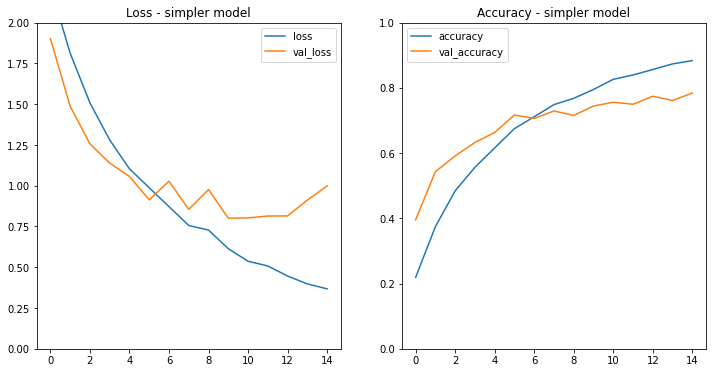

In [81]:
metrics_single_digits = history_single_digits.history

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_single_digits.epoch, metrics_single_digits['loss'], metrics_single_digits['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim(0, 2)
plt.title('Loss - simpler model')

plt.subplot(122)
plt.plot(history_single_digits.epoch, metrics_single_digits['accuracy'], metrics_single_digits['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim(0, 1)
plt.title('Accuracy - simpler model')
plt.show()

In [78]:
test_x, test_y = [], []

for x, y in test_ds:
    test_x.append(x)
    test_y.append(y)

test_x, test_y = np.array(test_x), np.array(test_y)

In [79]:
best_single_digit_model.evaluate(test_x, test_y)

41/41 [==============================] - 1s 19ms/step - loss: 1.0250 - accuracy: 0.8003


[1.0250310897827148, 0.8003060221672058]

In [85]:
y_test_proba = best_single_digit_model.predict(test_x)
y_test_pred = np.argmax(y_test_pred, axis=1)

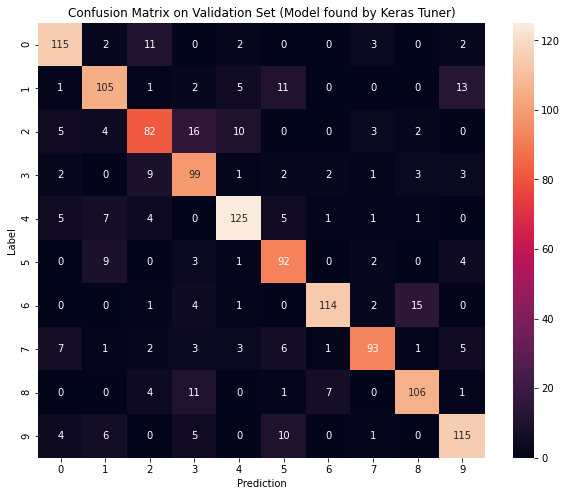

In [86]:
confusion_mtx = tf.math.confusion_matrix(test_y, y_test_pred) 
plt.figure(figsize=(10, 8))
sb.heatmap(confusion_mtx, xticklabels=list(range(0,10)), yticklabels=list(range(0,10)), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confusion Matrix on Validation Set (Model found by Keras Tuner)')
plt.show()

In [80]:
keras.models.save_model(best_single_digit_model, '/content/drive/MyDrive/Data/MLEnd/single_digit_CNN_20210410')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/MLEnd/single_digit_CNN_20210410/assets


In [18]:
best_single_digit_model = keras.models.load_model('/content/drive/MyDrive/Data/MLEnd/single_digit_CNN_20210410')

## Generating Sequence of Spoken Digits

The following generate a spoken sequence of digits by concatenating the audio samples provided by a random participant.

In [19]:
def get_random_participant():
    participant_digits = 0
    while True:
        # random participant
        random_participant = single_digits_df.participant.sample(1).values[0]

        # check if the participant has all ten digits
        cond = single_digits_df['participant'] == random_participant
        participant_digits = len(single_digits_df[cond].digit_label.unique())
        if participant_digits == 10:
            return random_participant

In [21]:
%mkdir -p /content/generated/

In [25]:
def digits_from_participant(participant_id, num_to_read):
    if isinstance(num_to_read, int):
        num_to_read = str(num_to_read)

    if not isinstance(num_to_read, str):
        raise RuntimeError('num_to_read must be int or str')

    cond1 = single_digits_df['participant'] == participant_id
    file_list = []
    for digit in num_to_read:
        try:
            cond2 = single_digits_df['digit_label'] == int(digit)
        except:
            raise RuntimeError('num_to_read can only contain digits')

        try:
            digit_filename = \
            single_digits_df[cond1 & cond2].sample(1)['File ID'].to_list()[0]
        except:
            raise RuntimeError('Participant does not exist or did not submit audio sample for the digit')
        else:
            file_list.append(digit_filename)

    data = []
    for audio_file in file_list:
        audio_wave = wave.open(audio_dir + audio_file, 'rb')
        data.append( [audio_wave.getparams(),
                      audio_wave.readframes(audio_wave.getnframes())] )
        audio_wave.close()

    output_name = f'/content/generated/{participant_id}_{num_to_read}.wav'
    output_file = wave.open(output_name, 'wb')
    output_file.setparams(data[0][0])
    for i in range(len(data)):
        output_file.writeframes(data[i][1])
    output_file.close()

    return output_name

In [26]:
random_audio_sample = digits_from_participant(get_random_participant(), random.randint(10000,1000000))

/content/generated/S45_642707.wav


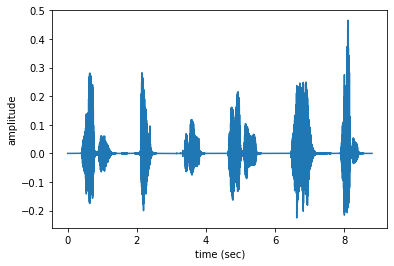

In [27]:
print(random_audio_sample)
display_audio(random_audio_sample, use_full_path=True)

## Predicting a Sequence of Digits

First we need to split the single audio file with a sequence of digits into chunks using ```pydub```.

This method split a recording into chunks on silence in an audio recording (in form on binary stream read using pydub). It writes the audio chunks into /content/recordings/ (specified in a variable in the above section) and returns the prefix of the file paths of the chunks.

In [29]:
# https://dataunbox.com/split-audio-files-using-python/
def split_recordings(audio_recording):
    #audio_recording = audio_recording.set_sample_width(2)
    audio_chunks = split_on_silence(audio_recording,
                                    min_silence_len=500,
                                    silence_thresh=-40)
    current_ts = datetime.now().strftime('%Y%m%d%H%M%S')
    prefix = f"recording_{current_ts}"

    for i, chunk in enumerate(audio_chunks):
        filename = f"{output_dir}/{prefix}_chunk{i}.wav"
        print("exporting", filename)
        #chunk = chunk.set_sample_width(2)
        chunk.export(filename, format="wav")
        
    return prefix

This method reads an audio file and call the method split_recordings() to split the audio file.


In [30]:
def split_wavefile(wavefile_path):
    wavefile = AudioSegment.from_wav(wavefile_path)
    return split_recordings(wavefile)

In [33]:
audio_prefix = split_wavefile('/content/generated/S45_642707.wav')

exporting /content/recordings/recording_20210410223516_chunk0.wav
exporting /content/recordings/recording_20210410223516_chunk1.wav
exporting /content/recordings/recording_20210410223516_chunk2.wav
exporting /content/recordings/recording_20210410223516_chunk3.wav
exporting /content/recordings/recording_20210410223516_chunk4.wav
exporting /content/recordings/recording_20210410223516_chunk5.wav


In [ ]:
audio_prefix = split_recordings(recorded_audio)

exporting /content/recordings/recording_20210328203415_chunk0.wav


In [34]:
audio_prefix

'recording_20210410223516'

Store the list of audio chunks in a dataframe, and then convert it to a TensorFlow dataset for prediction.

In [35]:
split_audio_files = glob.glob(f'{output_dir}/{audio_prefix}*.wav')
split_audio_files = sorted(split_audio_files)
split_audio_files = pd.DataFrame(split_audio_files)

In [36]:
def decode_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [41]:
recording_ds = filename_to_ds(split_audio_files[0])

In [42]:
input_x = []
for x in recording_ds:
    input_x.append(x)
    
input_x = np.array(input_x)

In [43]:
digits_proba = best_single_digit_model.predict(input_x)
digits_pred = np.argmax(digits_proba, axis=1)

The randomly generated number was 642 707. But the prediction only got half the digits correct (6, the first 7, 0).

In [44]:
digits_pred

array([6, 1, 3, 7, 0, 0])

# Discussion

The dataset contains 6533 audio samples of single digits, and in the advanced solution, the model was trained using 3919 samples, and 1307 were used for validation and another 1307 for testing.

This sample size looks enormous to a human, but perhaps it is not enough for a model to learn distinguish different digits, or different intonations in the basic solution.

There are a lot of different accents in spoken English. People of different native languages might pronouce the same word with some difference. Different people might have different interpretation of the same intonation. All these reasons could result in inevitable and difficult-to-control variability in the audio samples.

Also, the models built were borrowed from TensorFlow's tutorial, in which all audio samples were made to the same duration by adding silence to shorted audio samples. This was an easy way to make the input tensors to have a constant shape so that all audio samples could be fitted into the model. However, it was not known whether the added silence would have affected the prdiction, especially when it came to the prediction of single digits, which are generally shorter words.

One possible better way in doing so was to further trim the audio samples using libraries like ```pydub```, so that the amount of silence added to the audio samples could be reduced. But due to time constraints, this was not done in the mini-project.

In the basic solutions, a comparison was done between a simpler and a more "complex" convolutional neural network of classifying the intonations of the audio samples, it was shown that a more complext model did not do exceptionally better than the simple one. Frankly the more complext model found by Keras Tuner only contained one more densely connected layer than the simple model provided in TensorFlow's tutorial.

Considering the extra computing resources and time required in searching and training the a little more complex model, the simple model could be a better choice especially when both models don't out-perform each other in terms of perdiction accuracy.

